[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

We'll log to a project, `langchain-academy`. 

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching water bodies?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about rivers. But what others should I learn oceans?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching water bodies?
================================ Human Message =================================
Name: Lance

Yes, I know about rivers. But what others should I learn oceans?


Recall we can pass them to a chat model.

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-5-nano")
llm.invoke(messages)

Failed to multipart ingest runs: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


AIMessage(content='Nice question. If you already know rivers, here are other major water bodies and what makes each one interesting to study. You can pick and mix depending on your interests (geography, biology, climate, etc.).\n\n- Oceans and seas\n  - Oceans: the largest saltwater bodies; study their basins, depth, currents, tides, climate role.\n  - Seas: smaller saltwater areas connected to oceans; often partially enclosed (examples: Caribbean Sea, Baltic Sea).\n  - What to learn: major oceans, famous seas, differences between open-ocean and coastal dynamics, major currents.\n\n- Lakes and ponds\n  - Inland, freshwater (or sometimes saline in special cases); important for ecosystems, climate, and human use.\n  - What to learn: how they form (glacial, tectonic, volcanic), layering (thermocline), life in freshwater, examples of large lakes.\n\n- Wetlands\n  - Marshes, swamps, and bogs; water-saturated soils and rich biodiversity.\n  - What to learn: functions (flood control, habitat)

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


We can run our chat model in a simple graph with `MessagesState`.

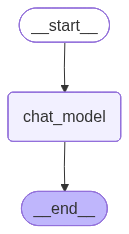

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


================================== Ai Message ==================================
Name: Bot

So you said you were researching water bodies?
================================ Human Message =================================
Name: Lance

Yes, I know about rivers. But what others should I learn oceans?
================================== Ai Message ==================================

Nice question, Lance. Besides rivers, here are the main types of water bodies you can learn about, with quick definitions and a familiar example for each:

- Oceans: the largest saltwater bodies; Earth has five. Examples: Pacific Ocean, Atlantic Ocean.
- Seas: smaller saltwater areas mostly connected to an ocean, often partly enclosed by land. Examples: Mediterranean Sea, Caribbean Sea.
- Bays and Gulfs: coastal indentations where the sea circles in toward land; gulfs are usually larger and more enclosed. Examples: San Francisco Bay (bay), Gulf of Mexico (gulf).
- Straits and Channels: narrow passages that connec

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

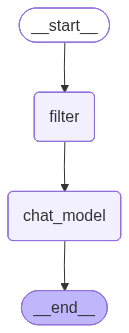

In [9]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph_reducer = builder.compile()

# View
display(Image(graph_reducer.get_graph().draw_mermaid_png()))

In [11]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Shiv", id="2"))
messages.append(AIMessage("So you said you were researching water bodies?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about rivers. But what others should I learn about like oceans?", name="Shiv", id="4"))

# Invoke
output = graph_reducer.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


================================== Ai Message ==================================
Name: Bot

So you said you were researching water bodies?
================================ Human Message =================================
Name: Shiv

Yes, I know about rivers. But what others should I learn about like oceans?
================================== Ai Message ==================================

Great question, Shiv. Besides oceans, there are several other major types of water bodies you can learn about. Here’s a quick map to get you started, with a short note on what makes each one special and an example.

- Seas and coastal waters
  - Seas are smaller than oceans and are often partially enclosed by land. Examples: Baltic Sea, Caribbean Sea.
  - They differ in salinity and ecosystems from open oceans and are important for regional weather and trade.

- Bays, gulfs, straits, and channels
  - Bays and gulfs are coastal indentations; gulfs are usually larger and more enclosed.
  - Straits are nar

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

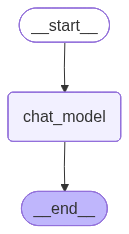

In [12]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]} # grab the last message

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph_filter = builder.compile()

# View
display(Image(graph_filter.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [13]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narmada river!", name="Shiv"))

In [14]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Shiv

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching water bodies?
================================ Human Message =================================
Name: Shiv

Yes, I know about rivers. But what others should I learn about like oceans?
================================== Ai Message ==================================

Great question, Shiv. Besides oceans, there are several other major types of water bodies you can learn about. Here’s a quick map to get you started, with a short note on what makes each one special and an example.

- Seas and coastal waters
  - Seas are smaller than oceans and are often partially enclosed by land. Examples: Baltic Sea, Caribbean Sea.
  - They differ in salinity and ecosystems from open oceans and

In [16]:
# Invoke, using message filtering
output = graph_filter.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Shiv

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching water bodies?
================================ Human Message =================================
Name: Shiv

Yes, I know about rivers. But what others should I learn about like oceans?
================================== Ai Message ==================================

Great question, Shiv. Besides oceans, there are several other major types of water bodies you can learn about. Here’s a quick map to get you started, with a short note on what makes each one special and an example.

- Seas and coastal waters
  - Seas are smaller than oceans and are often partially enclosed by land. Examples: Baltic Sea, Caribbean Sea.
  - They differ in salinity and ecosystems from open oceans and

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.
